# A3: Project on complex networks
### Analyzing Spotify Data: Global Patterns of Musical Taste and Artist/Genre Clustering by Country
#### _By Saioa Elizondo, Marc Albesa and Maria Fité_
**Group Name:** A3L

**Objective:** Development of a Project in which you put into practice some of the knowledge acquired
during this course on Complex Networks.

**Kind of project:** Analysis. Obtain real data which can be put in terms of network(s),
and analyze the network(s) to answer any question or hypothesis
about them. It is not enough to calculate descriptors or communities,
you must try to answer relevant questions about the system's
functioning.

## 0. Preparing the enviroment

In [1]:
%pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Code to import the needed modules/packages to run the notebook
import os
import pandas as pd # dataframes
import numpy as np # Mathematical operations
import matplotlib.pyplot as plt # Reçpresentation
import random as random
import networkx as nx # Network tools
import matplotlib.lines as mlines
import spotipy
from scipy.sparse.linalg import eigsh
from spotipy.oauth2 import SpotifyOAuth


# Get workng directory
wd = os.getcwd()

## 1. Importing data and constructing the network
### 1.1. Defining playlist IDs

In [3]:
playlist_ids = {
    "Catalonia": "5IczcOjRojDGQmphylNgAk",  
    "Spain": "7tk0qdAQnySyJC5NIC46LL",  
    "Argentina": "7hoGYwZsVAzxSeVDbABqEs",  
    "Brazil": "2vUqKjPCtiJN4AL0jVuSiQ",  
    "Italy": "0XxpxWDgSajIJubwjSG5p4",
    "France": "4Y9F9p3eOVnAnBdnWXgf3W",  
    "USA": "53aDM9BNWGgdbskDrMDBzd",  
    "Colombia": "3Oe6dTHiFHtJGu6CgIXvw2",  
    "UK": "0ZrNYP9GlN7C89nRcmb0ET", 
    "Ecuador": "0gb959SjjZBGj9tsOHpAjU",  
    "Mexico": "002EH6cGKQCzSl5XVJhub6", 
    "Chile": "7sEuTk63hXvwOyaku7G9oR", 
    "Russia": "0UBqxjbJs3nhI2Wexpd0tN", 
    "Germany": "0bk2WTv51p9vT5aplcHz3f", 
    "Portugal": "4LObto7Z2gRAH4o5H86EqQ", 
    "South Korea": "6Ah4okZFJJnDBjUiRhx0Uu",  
    "Venezuela": "6BRogt5aan10pDoueAcWgo",  
    "Morocco": "2zA1uaGEDg75UdcjZJER4e", 
    "Romania": "4jbgA8bDbQSDAjLAFKkTH9", 
    "Sweden": "0COXLs3GcoSx80UrlvXUUy",  
    "India": "4pbVk8P4zK0cL45qT6PgB1", 
    "Uruguay": "61HbuFG0J1Mc7SkEugwzYt",
    "Japan": "65M6poLBwAdYs0TD7qemPk",
    "Ireland": "4nmlpg46HQ1ctO6pbTAI1T", 
    "Dominican Republic": "4Krj4NmrOoWIALF3q3yanF",
    "Philippines": "5Ut79yzqJcHoOkUVJIqLWg", 
    "Indonesia": "5OazJo0Grq2aP6LsqP8cFP",
    "Austria":"4fxedQjEpyOwCox6Ug5PBi", 
    "Peru":"2dxdatUmtaLzJy4lAqPOl0",
    "Australia": "79Mjnq7qvaotdus0eXoYvy", 
}

### 1.2. Building the dataset

In [ ]:
# Set up credentials
client_id = '19107210277541c8a31c434e1d5d58c5'
client_secret = 'bf0216ea58b1471a976b1179aec337c5'  
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri='http://localhost:8888/callbackif',
    scope="playlist-read-private"
))

# Initialize empty dataframe
dataframe = pd.DataFrame()
genres_by_artist = dict()

# Fetch playlist tracks
for country, playlist_id in playlist_ids.items():
    print(f"Fetching playlist {playlist_id} for {country}")

    # Retrieve playlist items
    try:
        playlist_tracks = sp.playlist_items(playlist_id, market="global")
    except Exception as e:
        print(f"Error fetching playlist {playlist_id}: {e}")
        continue

    # Create and initialize dataframe entry
    country_artists = dict()
    country_artists = {"Country": country}

    for index, item in enumerate(playlist_tracks['items']):
        track = item["track"]

        # Fetch track stats
        Position = index + 1
        Album = track["album"]
        Popularity = track["popularity"]
        Artist = track["artists"][0]['name']
        artist_genres = sp.artist(track["artists"][0]['id']).get('genres', [])

        if Artist not in genres_by_artist.keys():
            genres_by_artist[Artist] = artist_genres

        # Compute popularity score (weight)
        popularity_score = (51-Position)

        # Check if the artist already in the country top50
        if Artist in country_artists.keys():
            country_artists[Artist] += popularity_score
        else: # Add as a new row
            country_artists[Artist] = popularity_score

    # Add the dictionary as a new row
    dataframe = pd.concat([dataframe, pd.DataFrame([country_artists])], ignore_index=True)

# Print DataFrame
dataframe.head()

Fetching playlist 5IczcOjRojDGQmphylNgAk for Catalonia
Fetching playlist 7tk0qdAQnySyJC5NIC46LL for Spain
Fetching playlist 7hoGYwZsVAzxSeVDbABqEs for Argentina
Fetching playlist 2vUqKjPCtiJN4AL0jVuSiQ for Brazil
Fetching playlist 0XxpxWDgSajIJubwjSG5p4 for Italy
Fetching playlist 4Y9F9p3eOVnAnBdnWXgf3W for France
Fetching playlist 53aDM9BNWGgdbskDrMDBzd for USA
Fetching playlist 3Oe6dTHiFHtJGu6CgIXvw2 for Colombia
Fetching playlist 0ZrNYP9GlN7C89nRcmb0ET for UK
Fetching playlist 0gb959SjjZBGj9tsOHpAjU for Ecuador


In [ ]:
# Save DataFrame to a CSV file
dataframe.to_csv(os.path.join(wd, "spotify_global_data.csv"), index=False)  # Set index=False to exclude the index column
print("DataFrame saved to 'spotify_global_data.csv'.")

# Read the CSV file and load it into a new DataFrame
spotify_global_data = pd.read_csv(os.path.join(wd, "spotify_global_data.csv"))
print("DataFrame loaded from 'spotify_global_data.csv':")

DataFrame saved to 'spotify_global_data.csv'.
DataFrame loaded from 'spotify_global_data.csv':


### 1.3. Converting the dataframe to a NetworkX bipartite graph

In [6]:
# Extract node types
country_nodes = list(spotify_global_data.iloc[:, 0])  # Rows represents countries
artist_nodes = list(spotify_global_data.columns[1:])  # Columns represent artists

# Initialize a bipartite graph
B = nx.Graph()

# Add nodes
B.add_nodes_from(country_nodes, bipartite=0)  # Bipartite group 0
B.add_nodes_from(artist_nodes, bipartite=1)  # Bipartite group 1

# Add edges with weights
for index, row in spotify_global_data.iterrows():
    node_a = row.iloc[0]  # First column (country)
    for node_b in artist_nodes:
        weight = row[node_b]
        if pd.notna(weight):  # Add edge if weight is not NaN
            B.add_edge(node_a, node_b, weight=weight)

# Output results
print("Nodes in the bipartite graph:")
print(B.nodes(data=True))
print("\nEdges in the bipartite graph:")
print(B.edges(data=True))

Nodes in the bipartite graph:
[('Catalonia', {'bipartite': 0}), ('Spain', {'bipartite': 0}), ('Argentina', {'bipartite': 0}), ('Brazil', {'bipartite': 0}), ('Italy', {'bipartite': 0}), ('France', {'bipartite': 0}), ('USA', {'bipartite': 0}), ('Colombia', {'bipartite': 0}), ('UK', {'bipartite': 0}), ('Ecuador', {'bipartite': 0}), ('Mexico', {'bipartite': 0}), ('Chile', {'bipartite': 0}), ('Russia', {'bipartite': 0}), ('Germany', {'bipartite': 0}), ('Portugal', {'bipartite': 0}), ('South Korea', {'bipartite': 0}), ('Venezuela', {'bipartite': 0}), ('Morocco', {'bipartite': 0}), ('Romania', {'bipartite': 0}), ('Sweden', {'bipartite': 0}), ('India', {'bipartite': 0}), ('Uruguay', {'bipartite': 0}), ('Japan', {'bipartite': 0}), ('Ireland', {'bipartite': 0}), ('Dominican Republic', {'bipartite': 0}), ('Philippines', {'bipartite': 0}), ('Indonesia', {'bipartite': 0}), ('Austria', {'bipartite': 0}), ('Peru', {'bipartite': 0}), ('Australia', {'bipartite': 0}), ('Alfred García', {'bipartite': 1})

## 2. Visualizing the network

In [7]:
# Defining geographical positions (longitude, latitude) for countries
country_positions = {
    "Catalonia": (1.8677, 41.8205), 
    "Spain": (-3.7492, 40.4637),
    "Argentina": (-63.6167, -38.4161),
    "Brazil": (-51.9253, -14.2350),
    "Italy": (12.5674, 41.8719),
    "France": (1.8883, 46.6034),
    "USA": (-95.7129, 37.0902),
    "Colombia": (-74.2973, 4.5709),
    "UK": (-3.4360, 55.3781),
    "Ecuador": (-78.1834, -1.8312),
    "Mexico": (-102.5528, 23.6345),
    "Chile": (-71.5430, -35.6751),
    "Russia": (105.3188, 61.5240),
    "Germany": (10.4515, 51.1657),
    "Portugal": (-8.2245, 39.3999),
    "South Korea": (127.7669, 35.9078),
    "Venezuela": (-66.5897, 6.4238),
    "Morocco": (-7.0926, 31.7917),
    "Romania": (24.9668, 45.9432),
    "Sweden": (18.6435, 60.1282),
    "India": (78.9629, 20.5937),
    "Uruguay": (-55.7658, -32.5228),
    "Japan": (138.2529, 36.2048),
    "Ireland": (-7.6921, 53.1424),
    "Dominican Republic": (-70.1627, 18.7357),
    "Philippines": (121.7740, 12.8797),
    "Indonesia": (113.9213, -0.7893),
    "Austria": (14.5501, 47.5162),
    "Peru": (-75.0152, -9.1900),
    "Australia": (133.7751, -25.2744),
}

In [8]:
# Helper function to separate overlapping nodes
def repel_nodes(positions, min_dist=0.1):
    for node1, pos1 in positions.items():
        for node2, pos2 in positions.items():
            if node1 != node2:
                dist = np.linalg.norm(np.array(pos1) - np.array(pos2))
                if dist < min_dist:  # If nodes are too close
                    direction = np.array(pos1) - np.array(pos2)
                    direction = direction / np.linalg.norm(direction) if np.linalg.norm(direction) != 0 else np.random.rand(2)
                    positions[node1] += direction * (min_dist - dist) * 0.5
                    positions[node2] -= direction * (min_dist - dist) * 0.5
    return positions

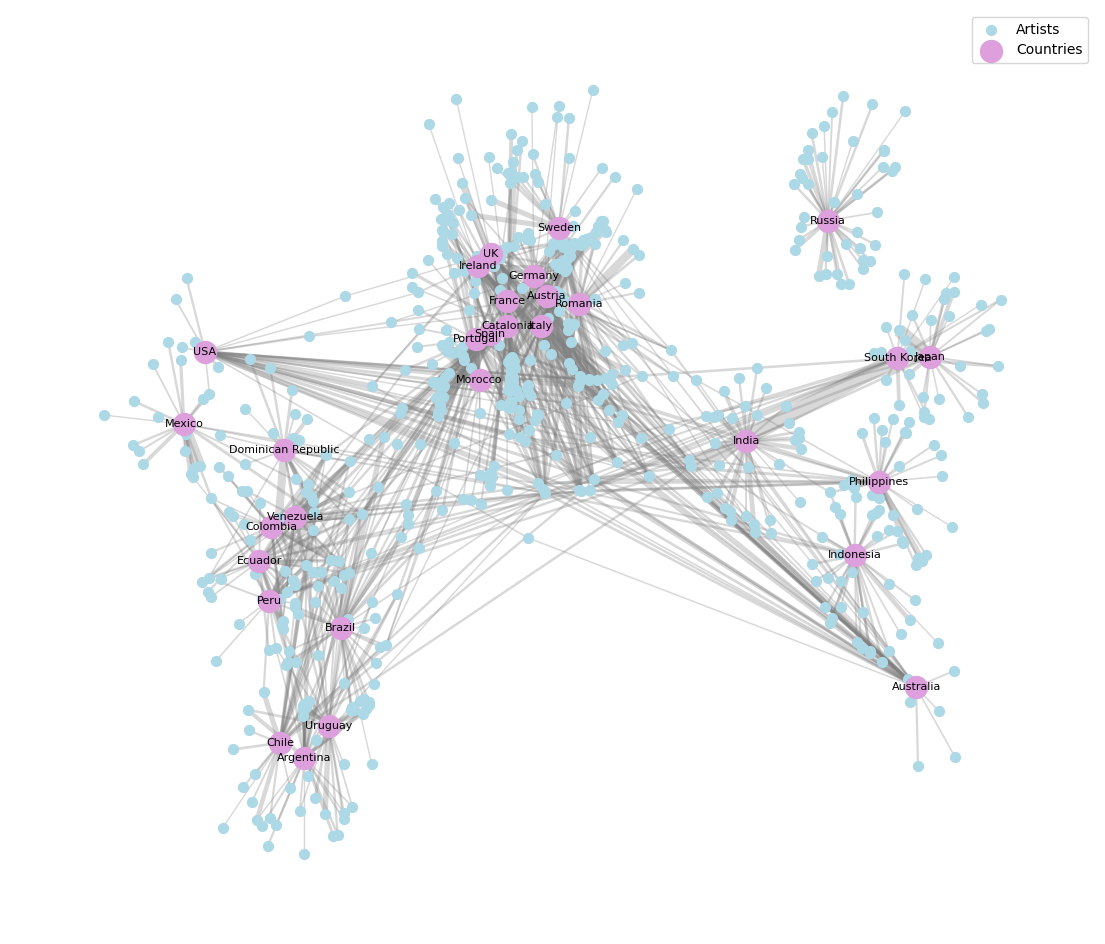

In [9]:
# Generate force-directed layout for artist nodes
country_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 0]
country_labels = {node: node for node in country_nodes}
artist_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 1]
artist_labels = {node: node for node in artist_nodes}

# Compute positions
fixed_positions = {node: pos for node, pos in country_positions.items() if node in country_nodes}
# Spring layout for artist nodes
positions = nx.spring_layout(B, pos=fixed_positions, fixed=country_nodes, weight="weight", iterations=50,k=5) 

# Apply repulsion to avoid overlapping nodes
artist_positions = {node: positions[node] for node in artist_nodes}
artist_positions = repel_nodes(artist_positions, min_dist=10)

# Combine back the positions, keeping country nodes fixed
for node in country_nodes:
    positions[node] = fixed_positions[node]
for node in artist_nodes:
    positions[node] = artist_positions[node]

# Separate positions for country and artist nodes
country_positions = {node: positions[node] for node in country_nodes}
artist_positions = {node: positions[node] for node in artist_nodes}

# Plotting
plt.figure(figsize=(14, 12))
edge_widths = [((data.get("weight", 1) - 1)/531)*(10)+1 for _, _, data in B.edges(data=True)]

# Draw nodes
nx.draw_networkx_nodes(B, positions, nodelist=artist_nodes, node_size=50, node_color="lightblue", label="Artists")
nx.draw_networkx_nodes(B, positions, nodelist=country_nodes, node_size=250, node_color="plum", label="Countries")
nx.draw_networkx_labels(B, country_positions, labels=country_labels, font_size=8, font_color="black")

# Draw edges
nx.draw_networkx_edges(B, positions, edge_color="gray", alpha=0.3, width=edge_widths)

plt.legend()
plt.gca().set_frame_on(False)
plt.show()

## 3. Regional claustering of top artists

The main goal of this section is to explore whether countries within the same geographical region tend to have a more similar musical taste.

First of all we need to create a bipartite network with two types of nodes. One type corresponds to the different countries and the other type to the name of the artists. Each artist is linked to a country if it appears in the playlist of a given country. Once done that, as we are interested only in countries, we will project the bipartite network onto a unipartite graph of countries. This will give rise to a network consisting in the different countries as nodes, where weights are automatically computed as the number of common neighbors (artists).

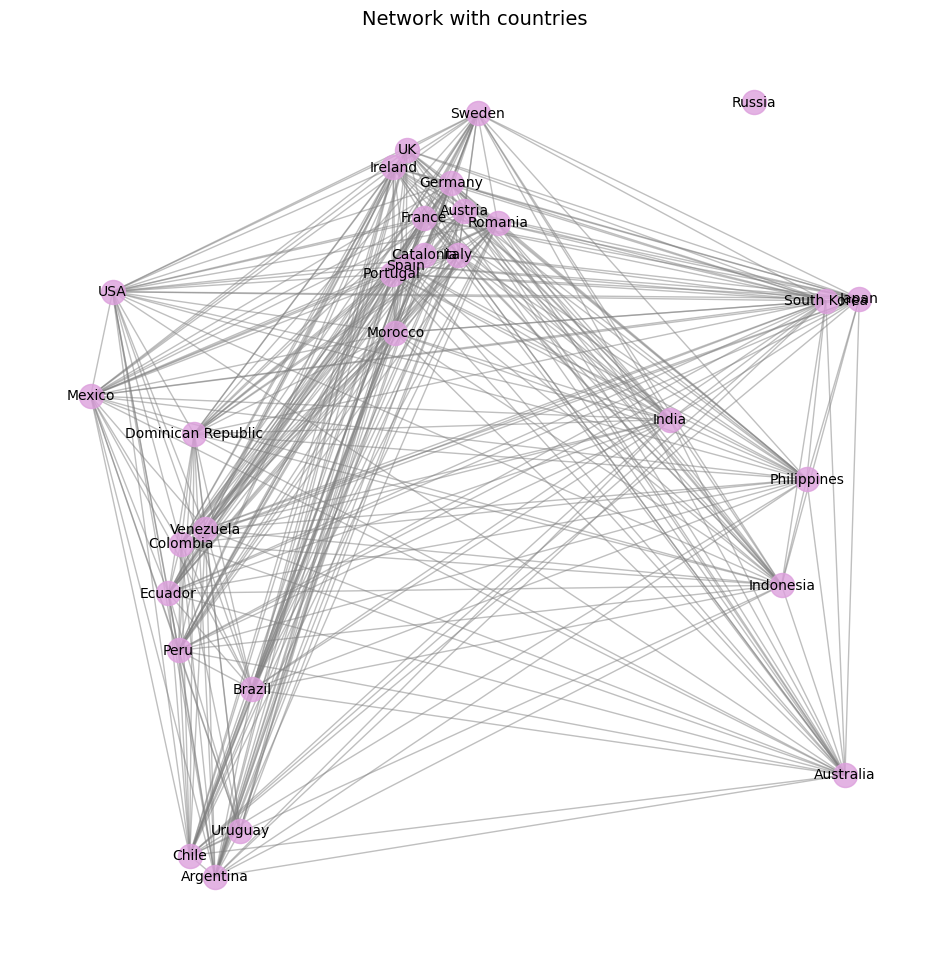

In [ ]:
# Extract node types
country_nodes = list(spotify_global_data.iloc[:, 0])  # Rows represents countries
artist_nodes = list(spotify_global_data.columns[1:])  # Columns represent artists

# Create a bipartite graph
G = nx.Graph()
country_nodes = list(spotify_global_data.iloc[:, 0])  # Rows represents countries
artist_nodes = list(spotify_global_data.columns[1:])  # Columns represent artists
G.add_nodes_from(country_nodes, bipartite=0)
G.add_nodes_from(artist_nodes, bipartite=1)
for index, row in spotify_global_data.iterrows():
    node_a = row.iloc[0]  # First column (country)
    for node_b in artist_nodes:
        weight = row[node_b]
        if pd.notna(weight):  # Add edge if weight is not NaN
            G.add_edge(node_a, node_b, weight=1)

# Project the graph onto the set of countries
country_graph = nx.bipartite.weighted_projected_graph(G, country_nodes)

# Display graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(country_graph, seed=42)
nx.draw_networkx_nodes(country_graph, country_positions, node_color="plum", node_size=300, alpha=0.8)
nx.draw_networkx_edges(country_graph, positions, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(country_graph, country_positions, font_size=10, font_color="black")
plt.title("Network with countries", fontsize=14)
plt.axis('off')
plt.show()

Once having the network, we will apply a Louvian community detection algorithm in order to detect comunities acording to the similarity in artists among different countries.

In [11]:
import community.community_louvain as community_louvain

# Compute the best partition
partition = community_louvain.best_partition(country_graph, weight='weight')

# Add communities to node attributes
nx.set_node_attributes(country_graph, partition, 'community')

Now we will plot the Network with the countries where edge thickness is proportional to similarity and node color indicates the community membership.

/var/folders/25/_t9_ysbj231g4ky2h62hjrsr0000gn/T/ipykernel_33858/2227292148.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(communities))


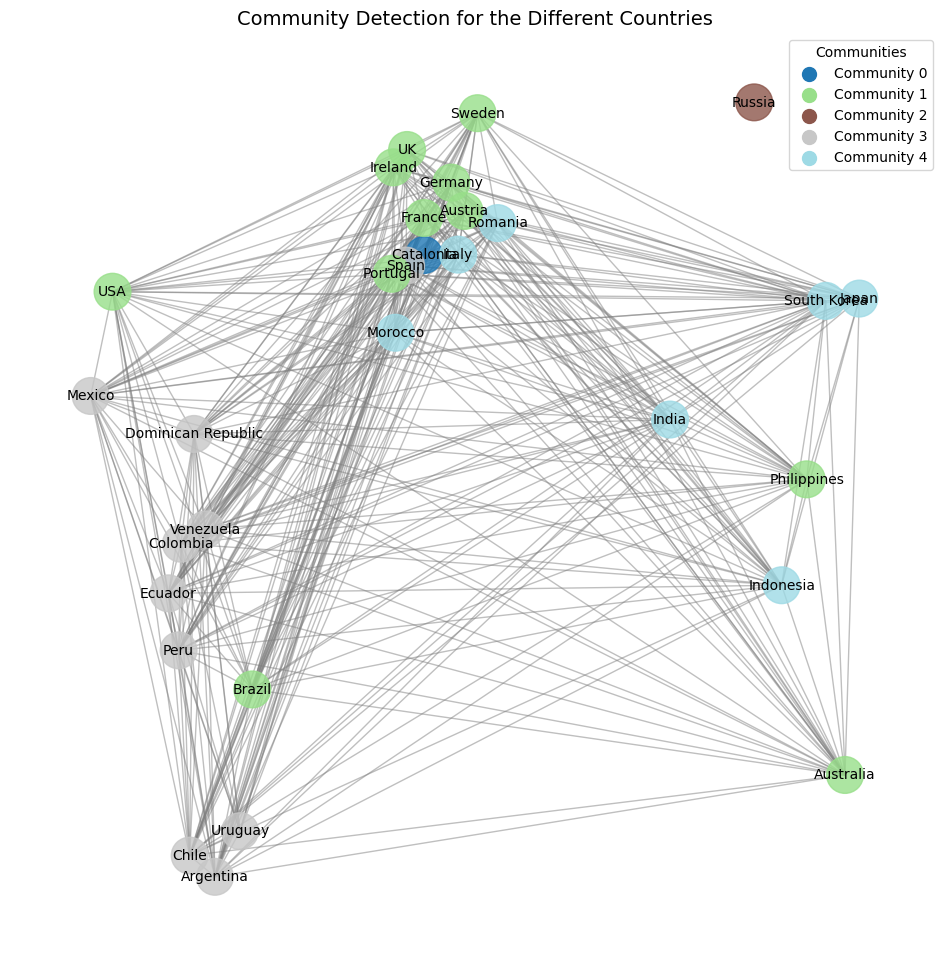

In [ ]:
import matplotlib.cm as cm

# Each community gets a unique color
communities = set(partition.values())
color_map = cm.get_cmap('tab20', len(communities))
colors = {community: color_map(i) for i, community in enumerate(communities)}

# Make plot
plt.figure(figsize=(12, 12))

# Get node colors
node_colors = [colors[partition[node]] for node in country_graph.nodes()]

# Draw the graph
nx.draw_networkx_nodes(country_graph, country_positions, node_color=node_colors, node_size=700, alpha=0.8)
nx.draw_networkx_edges(country_graph, positions, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(country_graph, country_positions, font_size=10, font_color="black")

# Add legend for communities
for comm_id, color in colors.items():
    plt.scatter([], [], color=color, label=f'Community {comm_id}', s=100)
plt.legend(scatterpoints=1, frameon=True, title="Communities", loc='best')

# Add title and show plot
plt.title("Community Detection for the Different Countries", fontsize=14)
plt.axis('off')
plt.show()


Additionally, we will also print a dictionary where keys are the different comunities and the values inside the key the countries belonging to that comunity.

In [13]:
from collections import defaultdict

communities = defaultdict(list)
for country, comm_id in partition.items():
    communities[comm_id].append(country)
for comm_id, countries in communities.items():
    print(f"Comunity {comm_id}: {', '.join(map(str, countries))}")

Comunity 0: Catalonia
Comunity 3: Spain, Argentina, Colombia, Ecuador, Mexico, Chile, Venezuela, Uruguay, Dominican Republic, Peru
Comunity 1: Brazil, France, USA, UK, Germany, Portugal, Sweden, Ireland, Philippines, Austria, Australia
Comunity 4: Italy, South Korea, Morocco, Romania, India, Japan, Indonesia
Comunity 2: Russia


Our algorithm has been capable of detecting 5 different comunities. First of all we can see that Russia and Catalonia are alone in their own comunity. This fact might be due to that they listent to local artists and they are not much related to other countries regarding to musical taste. Additionally, we can see that Latin America and Spain are detected to be an other different comunity, this makes sense if we consider the language spoken in those countries, as they might listen to Spanish-speaker artists. Moreover, asiatic countries seem to be grouped in another comunity, as they might support artist that are from the continent. Finally, European countries, Australia, USA and Brasil seem to shear the same comunity. This fact could be due to the intense relationship in culture and the globalization that makes all those countries close to each other regarding to music taste.

## 4. Genre Diversity by Country

The main goal of thsi section is to study countries with a wider variety of most-listened genres and relate to the cultural diversity of each country.

First of all we need to create a bipartite network with two types of nodes. One type corresponds to the different countries and the other type the genere. Each genere is linked to a country if it appears in the playlist of a given country. To calculate the weights, the genere of the artist is checked. If it is asigned to more than one genere a weight of one is devided into the total number of generes, contrary it is assigned to 1. The total weight of a link between genere and country is the result of the sum of the weight contribution of each song.

In [ ]:

track_id = "3n3Ppam7vgaVa1iaRUc9Lp"  # Example: "Mr. Brightside" by The Killers

# Get track details
track = sp.track(track_id)
artists = track['artists']  # Get the list of artists for the track

# Fetch genres for each artist
for artist in artists:
    artist_id = artist['id']
    artist_info = sp.artist(artist_id)  # Get artist details
    genres = artist_info.get('genres', [])  # Get genres
    print(f"Artist: {artist['name']}")
    print(f"Genres: {', '.join(genres) if genres else 'No genres available'}")

Artist: The Killers
Genres: alternative rock, dance rock, modern rock, permanent wave, rock


In [15]:
# Calculate weights in the network
country_genre_weights = defaultdict(lambda: defaultdict(float))

# Add edges with weights
for index, row in spotify_global_data.iterrows():
    node_a = row.iloc[0]  # First column (country)
    for node_b in artist_nodes:
        if pd.notna(row[node_b]):
            generes = genres_by_artist[node_b]
            # Equal weight for each genre the artist belongs to
            genre_weight = 1 / len(generes) if len(generes) !=0 else 0
            # Add weight for each genre in this country
            for genre in generes:
                country_genre_weights[node_a][genre] += genre_weight

# Create graph
G_genere = nx.Graph()
for country, genres in country_genre_weights.items():
    G_genere.add_node(country, bipartite=0)  # Country node
    for genre, weight in genres.items():
        G_genere.add_node(genre, bipartite=1)  # Genre node
        G_genere.add_edge(country, genre, weight=weight)

Now we will display the graph obtained.

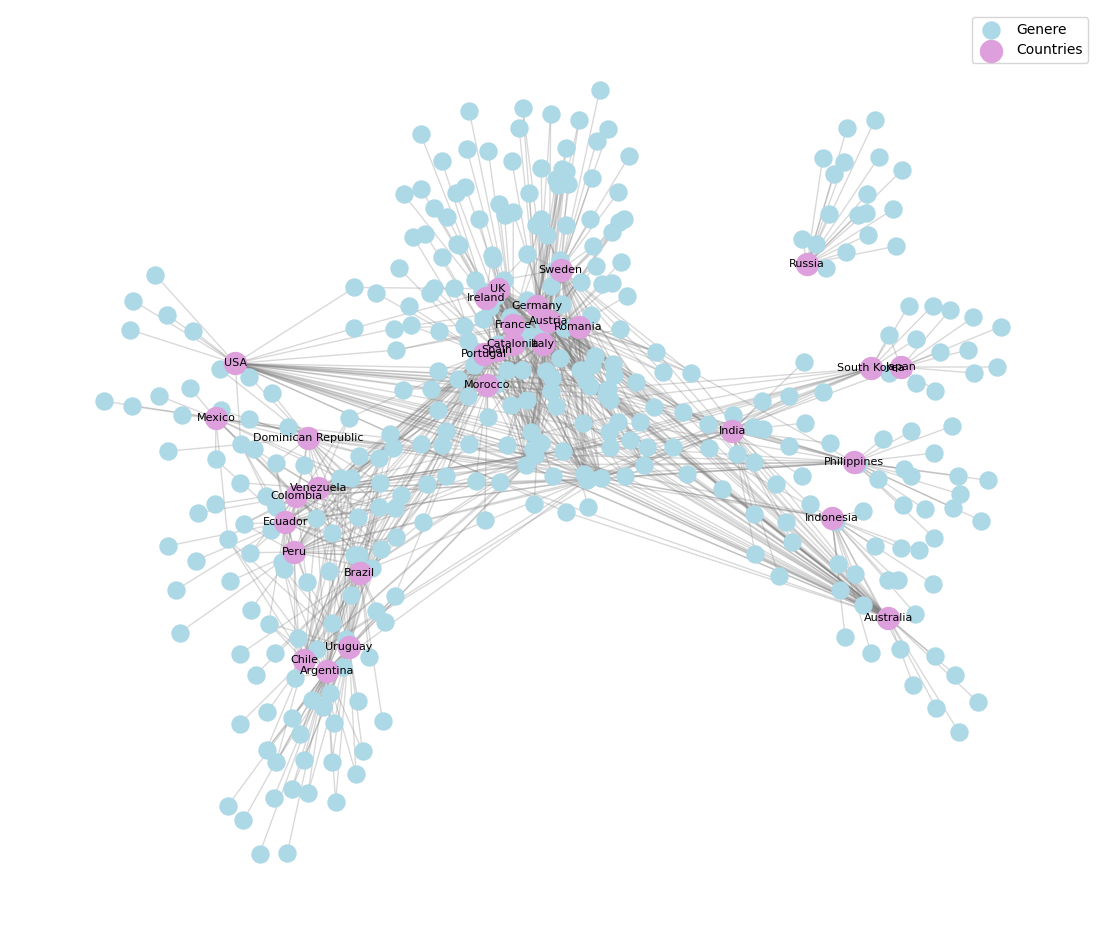

In [ ]:
# Generate force-directed layout for genere nodes
country_nodes = [node for node, data in G_genere.nodes(data=True) if data.get("bipartite") == 0]
country_labels = {node: node for node in country_nodes}
genere_nodes = [node for node, data in G_genere.nodes(data=True) if data.get("bipartite") == 1]
genere_labels = {node: node for node in genere_nodes}

# Ensure that all country nodes have positions
fixed_positions = {node: pos for node, pos in country_positions.items() if node in country_nodes}
for node in country_nodes:
    if node not in fixed_positions:
        fixed_positions[node] = np.random.rand(2)  # Random position for missing nodes

# Spring layout for genere nodes, with country nodes fixed
positions = nx.spring_layout(G_genere, pos=fixed_positions, fixed=country_nodes, weight="weight", iterations=50, k=5)

# Apply repulsion to avoid overlapping nodes
genere_positions = {node: positions[node] for node in genere_nodes}
genere_positions = repel_nodes(genere_positions, min_dist=10)

# Combine position keeping country fixed
for node in country_nodes:
    positions[node] = fixed_positions[node]
for node in genere_nodes:
    positions[node] = genere_positions[node]

# Separate positions for country and artist nodes
country_positions = {node: positions[node] for node in country_nodes}
genere_positions = {node: positions[node] for node in genere_nodes}

# Plotting
plt.figure(figsize=(14, 12))

# Draw nodes
nx.draw_networkx_nodes(G_genere, positions, nodelist=genere_nodes, node_size=150, node_color="lightblue", label="Genere")
nx.draw_networkx_nodes(G_genere, positions, nodelist=country_nodes, node_size=250, node_color="plum", label="Countries")

# Draw labels
nx.draw_networkx_labels(G_genere, country_positions, labels=country_labels, font_size=8, font_color="black")

# Draw edges
edge_widths = [((data.get("weight", 1) - 1) / 531) * (10) + 1 for _, _, data in G_genere.edges(data=True)] # Edge widths based on weight
nx.draw_networkx_edges(G_genere, positions, edge_color="gray", alpha=0.3, width=edge_widths)

# Display legend and plot
plt.legend()
plt.gca().set_frame_on(False)
plt.show()

Once the network is created, in order to determine the diversity of generes, the degree of the different countries is computed. A higher degree indicates that the country is linked to more generes, and so, it has a higher genere diversity.

In [ ]:
# Compute degrees for countries
countries = [node for node, data in G_genere.nodes(data=True) if data.get("bipartite") == 0]
country_degrees_notordered = {country: G_genere.degree(country) for country in countries}
country_degrees = {k: country_degrees_notordered[k] for k in sorted(country_degrees_notordered, key=lambda x: country_degrees_notordered[x], reverse=True)}


# Display results
print("Country Degree (Number of Connected Genres):")
for country, degree in country_degrees.items():
    print(f"{country}: {degree}")

Country Degree (Number of Connected Genres):
Austria: 55
Germany: 49
Australia: 48
Sweden: 44
Argentina: 43
Ireland: 41
UK: 40
Portugal: 39
USA: 36
Ecuador: 33
Uruguay: 33
Peru: 32
France: 31
Philippines: 31
Spain: 30
Colombia: 25
Chile: 25
Brazil: 24
India: 24
Italy: 23
Venezuela: 23
Dominican Republic: 23
Indonesia: 22
Morocco: 20
Russia: 18
Mexico: 17
South Korea: 16
Catalonia: 13
Japan: 12
Romania: 11


In orter to see graphycally the results, we will make a bar chart with the results obtained.

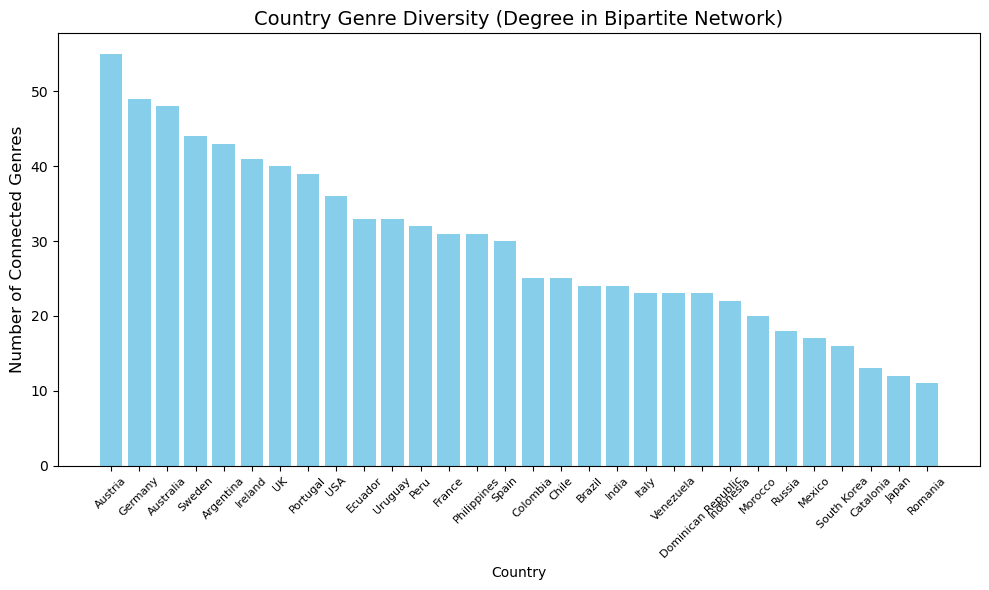

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(country_degrees.keys(), country_degrees.values(), color="skyblue")
plt.title("Country Genre Diversity (Degree in Bipartite Network)", fontsize=14)
plt.xlabel("Country", fontsize=10)
plt.ylabel("Number of Connected Genres", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

It can be seen that different countries clearly seem to have very differnt music genere diversity, this fact can be explained to different factors. First of all, countries with higher music diversity tend to have more immigartion, which enhances the consumption of different music styles. Additionally, globalization helps to get easier to different types of music and consum it.

## Q3: Global Superstars Dominate Across Countries: 
We aim to identify the artists who dominate the top artist rankings across the majority of countries. Artists with the highest degree centrality in a bipartite network are those connected to the most countries, making them global superstars. To begin, we will analyze the degree centrality distribution of the artists:

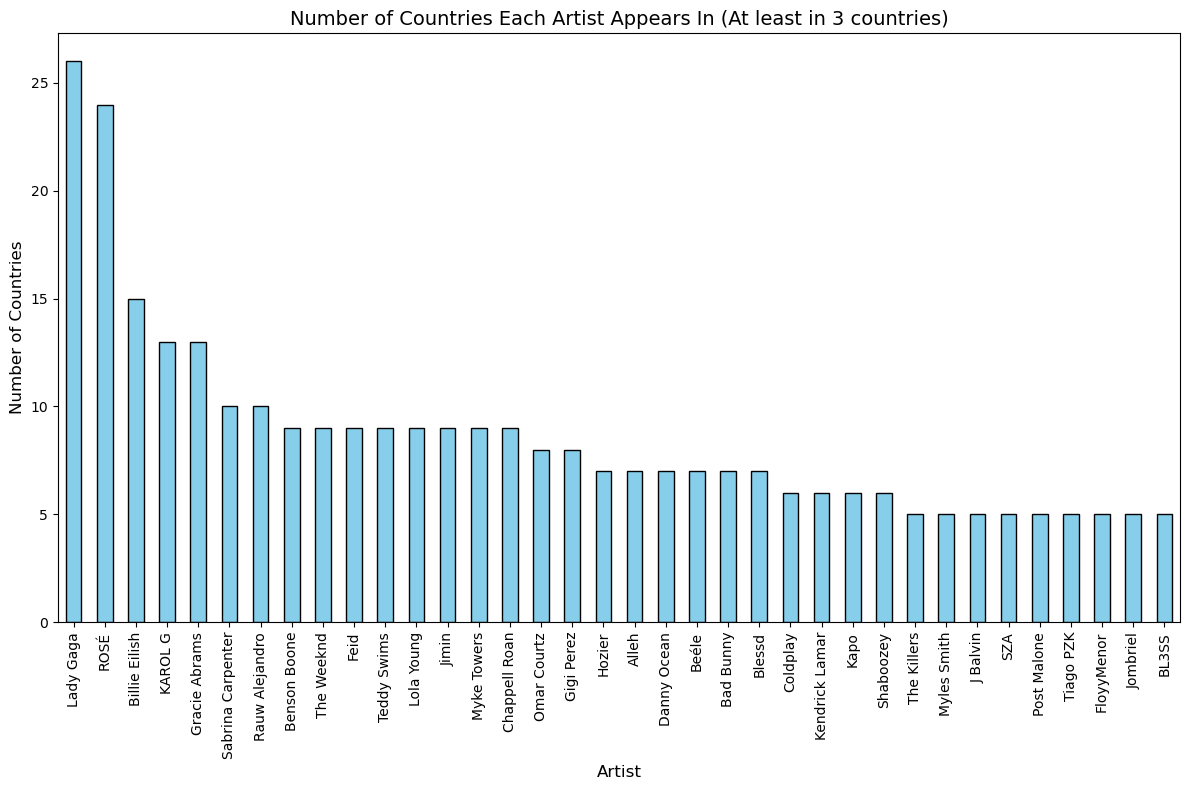

In [ ]:
# Count how many countries each artist appears in
artist_country_counts = spotify_global_data.iloc[:, 1:].apply(lambda x: (x > 0).sum(), axis=0)

# Filter out artists who appear less than 5 countries
filtered_artist_counts = artist_country_counts[artist_country_counts > 4]

# Sort artists by the number of countries they appear in (descending order)
sorted_artist_counts = filtered_artist_counts.sort_values(ascending=False)

# Create a bar plot for the number of countries each artist appears in
plt.figure(figsize=(12, 8))
sorted_artist_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Countries Each Artist Appears In (At least in 3 countries)', fontsize=14)
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(rotation=90)  

plt.tight_layout()
plt.show()


In this analysis, we define global superstars as artists who exhibit both widespread influence and high popularity. We use two criteria to identify them: 
1. Cumulative popularity, which reflects the total success of an artist across all countries, ensuring that only highly popular artists are considered. 
2. We look at how often an artist appears in the top 10 rankings across multiple countries. An artist who frequently appears in the top 10 of many countries demonstrates consistent global appeal. 

Combining these two factors allows us to distinguish artists who are not only popular but also maintain a strong and consistent presence across the globe, making them true global superstars.

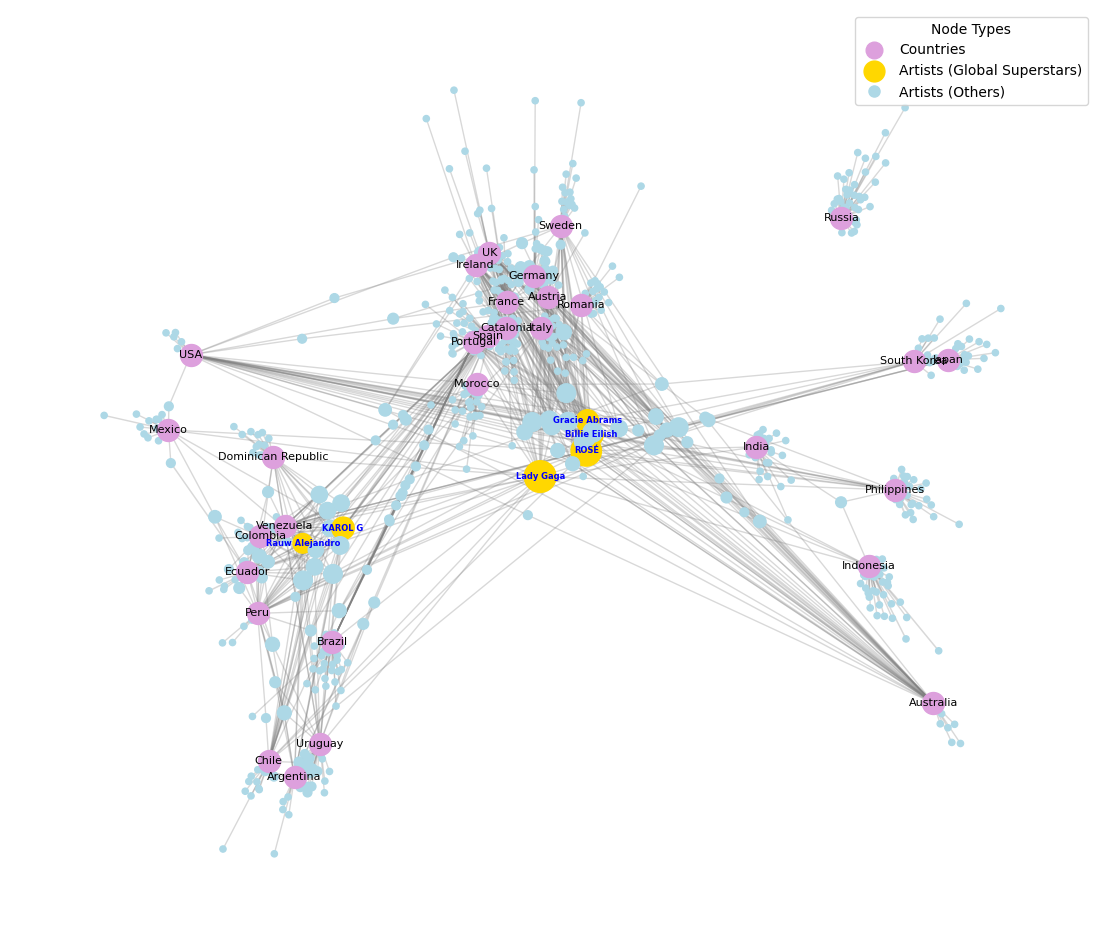

In [22]:
positions = nx.spring_layout(B, pos=fixed_positions, fixed=country_nodes, weight="weight", iterations=50,k=5) 

# We first calculate cumulative popularity scores
artist_popularity = spotify_global_data.iloc[:, 1:].sum(axis=0)  # Sum popularity across countries
artist_popularity = artist_popularity.sort_values(ascending=False)

# Find artists in the top 10 for each country
top_10_artists_by_country = spotify_global_data.iloc[:, 1:].apply(
    lambda row: row.nlargest(10).index.tolist(), axis=1
)
top_10_flat = [artist for sublist in top_10_artists_by_country for artist in sublist]

# Count the number of times each artist appears in the top 10
artist_top_10_counts = pd.Series(top_10_flat).value_counts()

# We define "global superstars" as artists with high popularity and frequent top-10 appearances
superstar_threshold = artist_popularity.mean()  # Use mean popularity as a threshold
top_10_threshold = len(spotify_global_data) * 0.2  # Appear in top 10 for at least 20% of countries

global_superstars = artist_top_10_counts[
    (artist_popularity.loc[artist_top_10_counts.index] > superstar_threshold) &
    (artist_top_10_counts > top_10_threshold)
].index

# We will highlight global superstars in the graph with a golden colour and bigger size

artist_node_sizes = [
    20 * B.degree(artist) for artist in artist_nodes  # Scale size by degree
]
artist_node_colors = [
    "gold" if artist in global_superstars else "lightblue" for artist in artist_nodes
]

plt.figure(figsize=(14, 12))

# Draw artist nodes with updated sizes and colors
nx.draw_networkx_nodes(
    B, positions, nodelist=artist_nodes,
    node_size=artist_node_sizes, node_color=artist_node_colors, label="Artists"
)

# Draw country nodes 
nx.draw_networkx_nodes(
    B, positions, nodelist=country_nodes,
    node_size=250, node_color="plum", label="Countries"
)

nx.draw_networkx_edges(B, positions, edge_color="gray", alpha=0.3, width=edge_widths)


nx.draw_networkx_labels(B, country_positions, labels=country_labels, font_size=8, font_color="black")

# Add labels only for global superstars
superstar_labels = {artist: artist for artist in artist_nodes if artist in global_superstars}
nx.draw_networkx_labels(
    B, positions, labels=superstar_labels, font_size=6, font_color="blue", font_weight="bold"
)

# Create legend elements
country_legend = mlines.Line2D([],[],color="plum", marker='o', markersize=12, linestyle='None', label="Countries")
superstar_legend = mlines.Line2D([], [], color="gold", marker='o', linestyle='None',
                                 markersize=15, label="Artists (Global Superstars)")
artist_legend = mlines.Line2D([], [], color="lightblue", marker='o', linestyle='None',
                              markersize=8, label="Artists (Others)")

# Add to the legend
plt.legend(handles=[country_legend, superstar_legend, artist_legend],
           loc="upper right", fontsize=10, title="Node Types")

plt.gca().set_frame_on(False)
plt.show()


## Q4- Regional Preferences

We aim to analyze which countries most actively support their local and regional artists. Since we lack direct information about the nationality of artists, we will categorize them based on their geographic presence. Specifically:

- Local artists are defined as those who appear in exactly one country (degree = 1), indicating they are primarily active in a single country.
- Regional artists are those who appear in 2 to 5 countries, suggesting a broader regional influence.
- Global artists are those who appear in more than 5 countries, representing a worldwide presence.

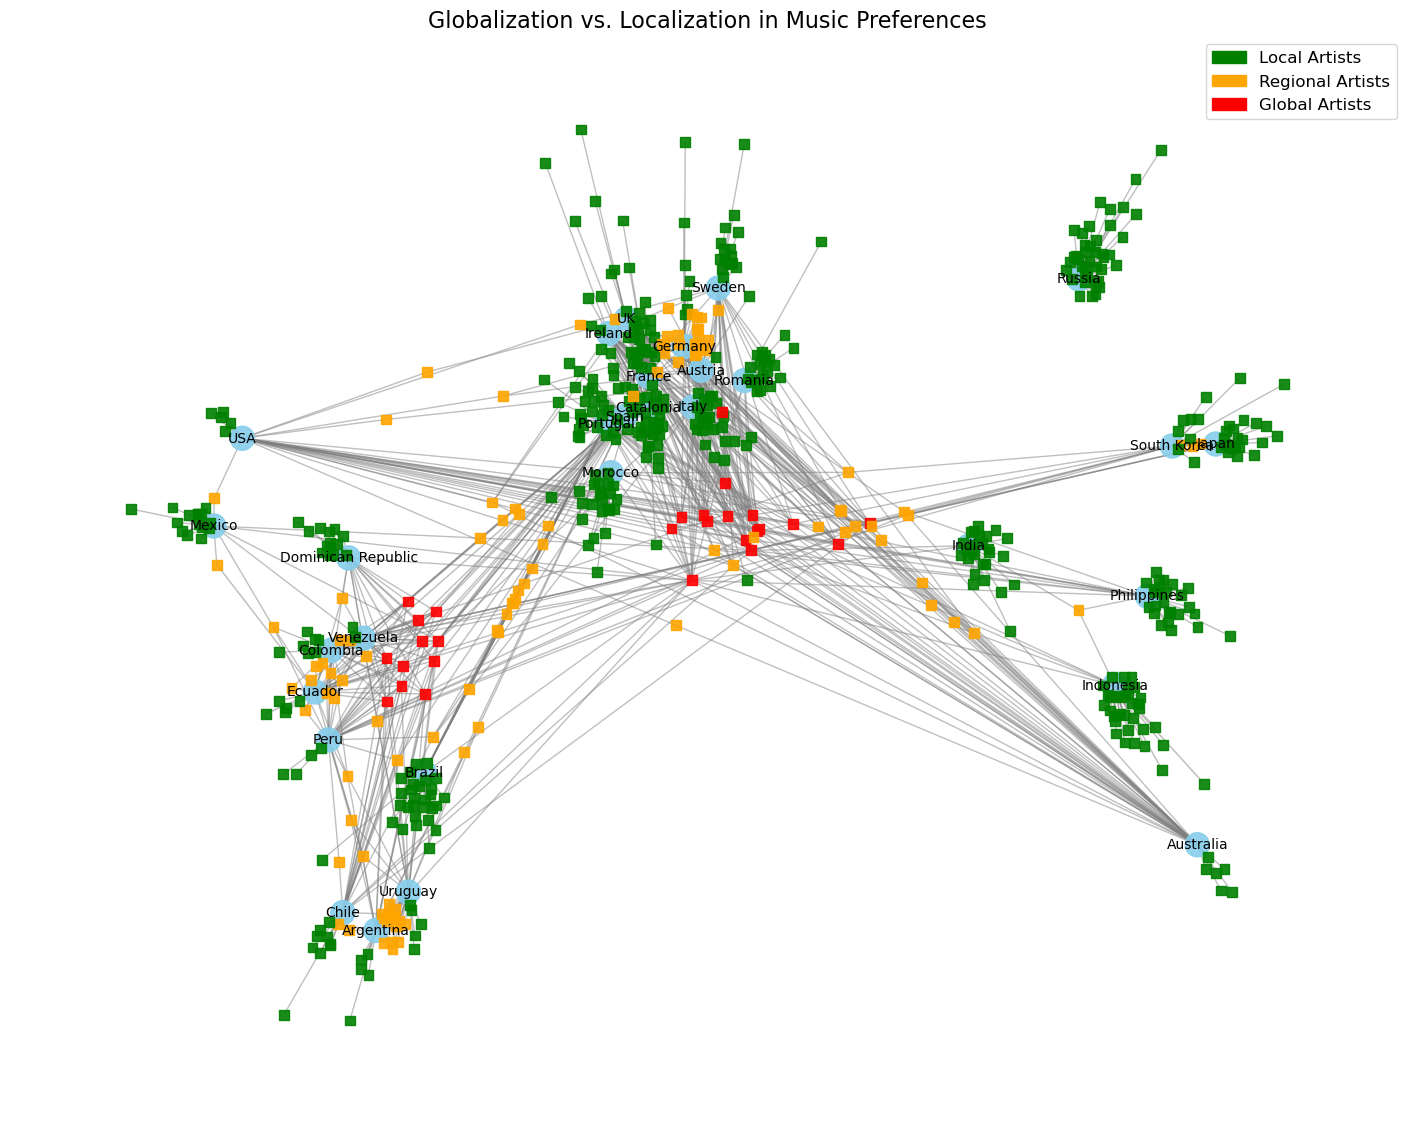

In [ ]:
import matplotlib.patches as mpatches

# Extract artist names (columns except the first one)
artist_nodes = spotify_global_data.columns[1:]

# Calculate the number of countries each artist appears in
artist_country_counts = spotify_global_data[artist_nodes].notna().sum(axis=0)

# Define thresholds for local, regional, and global artists
local_threshold = 1  # Appears in exactly 1 country
regional_lower_bound = 2  # Appears in 2 countries
regional_upper_bound = 5  # Appears in up to 5 countries

global_threshold = 5  # Appears in >5 countries 

# Categorize artists based on the thresholds
artist_categories = {}
for artist, count in artist_country_counts.items():
    if count == local_threshold:
        artist_categories[artist] = "Local"
    elif regional_lower_bound <= count <= regional_upper_bound:
        artist_categories[artist] = "Regional"
    elif count > global_threshold:
        artist_categories[artist] = "Global"
    else:
        artist_categories[artist] = "Other"

artist_category_df = pd.DataFrame.from_dict(artist_categories, orient='index', columns=['Category'])

# Count the number of artists in each category
category_counts = artist_category_df['Category'].value_counts()

# Map artist categories to colors
artist_color_map = {
    "Local": "green",
    "Regional": "orange",
    "Global": "red"
}

# Assign node colors and shapes based on classification
node_colors = []
node_shapes = []
node_sizes = []

for node, data in B.nodes(data=True):
    if data.get("bipartite") == 0:  # Country nodes
        node_colors.append("skyblue")
        node_shapes.append("o")  # Circular shape for countries
        node_sizes.append(300)
    else:  # Artist nodes
        artist_category = artist_categories.get(node, "Other")
        node_colors.append(artist_color_map.get(artist_category))  
        node_shapes.append("s")  # Square shape for artists
        node_sizes.append(50)


plt.figure(figsize=(18, 14))

# Draw edges
nx.draw_networkx_edges(
    B,
    pos=positions,
    edgelist=B.edges(data=True),
    width=edge_widths,
    alpha=0.5,
    edge_color="gray",
)

# Separate node drawing for different shapes
for shape, bipartite_group in [("o", 0), ("s", 1)]:
    shape_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == bipartite_group]
    shape_positions = {node: positions[node] for node in shape_nodes}
    shape_colors = [node_colors[i] for i, node in enumerate(B.nodes()) if node in shape_nodes]
    shape_sizes = [node_sizes[i] for i, node in enumerate(B.nodes()) if node in shape_nodes]

    nx.draw_networkx_nodes(
        B,
        pos=shape_positions,
        nodelist=shape_nodes,
        node_color=shape_colors,
        node_size=shape_sizes,
        node_shape=shape,
        alpha=0.9,
    )

# Add labels for countries
nx.draw_networkx_labels(B, pos=country_positions, labels=country_labels, font_size=10, font_color="black")

# Create legend entries for the node colors and shapes
local_patch = mpatches.Patch(color='green', label='Local Artists')
regional_patch = mpatches.Patch(color='orange', label='Regional Artists')
global_patch = mpatches.Patch(color='red', label='Global Artists')

# Add the legend to the plot
plt.legend(handles=[local_patch, regional_patch, global_patch], loc='upper right', fontsize=12)

plt.title("Globalization vs. Localization in Music Preferences", fontsize=16)
plt.axis("off")
plt.show()


<Figure size 1400x800 with 0 Axes>

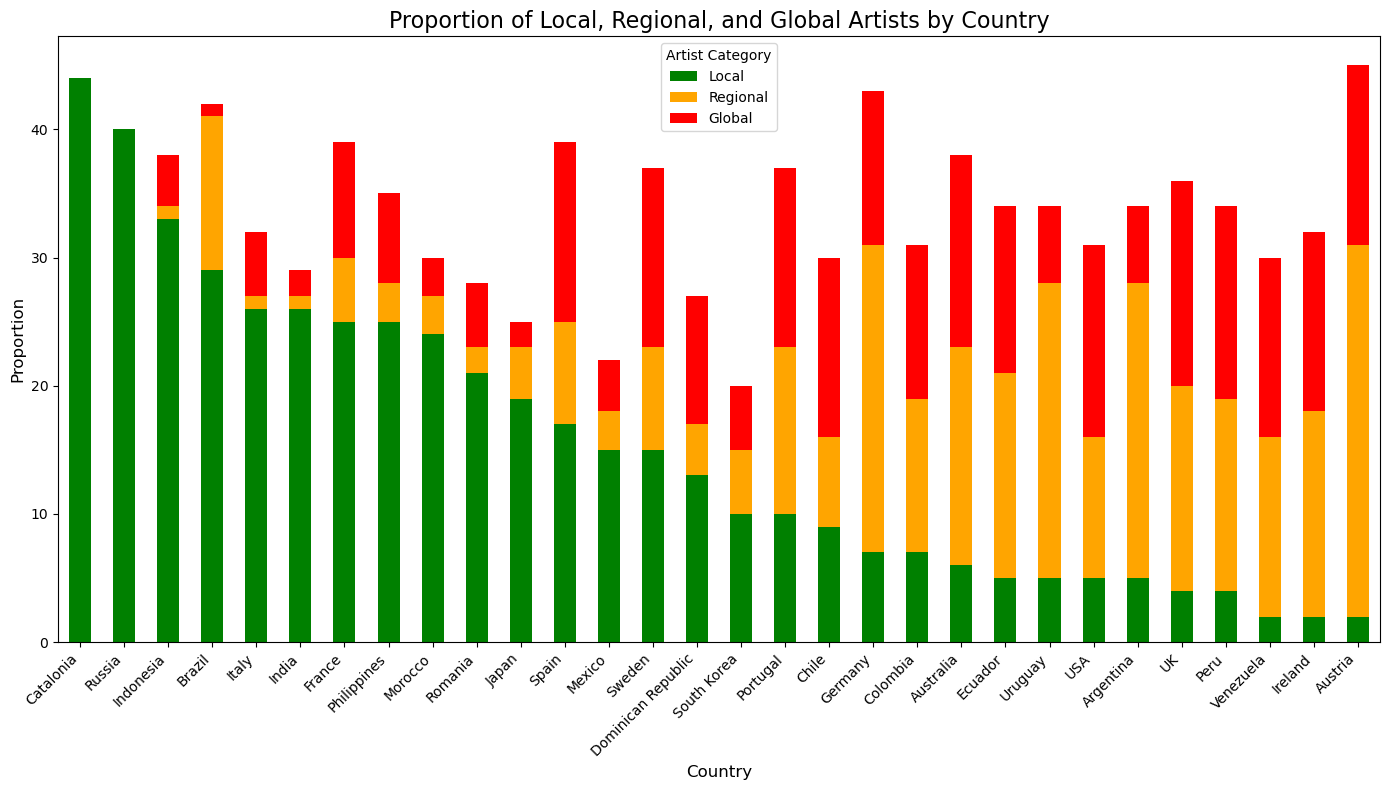

In [ ]:
# Prepare data for the stacked bar chart
country_artist_categories = {
    country: {"Local": 0, "Regional": 0, "Global": 0}
    for country in spotify_global_data.iloc[:, 0]
}

# Populate counts based on artist categories
for country in spotify_global_data.iloc[:, 0]:
    country_artists = spotify_global_data.loc[spotify_global_data.iloc[:, 0] == country, artist_nodes]
    country_artist_counts = country_artists.notna().sum(axis=0)
    country_included_artists = country_artist_counts[country_artist_counts > 0]
    for artist, count in country_included_artists.items():
        category = artist_categories.get(artist, "Other")
        if category in country_artist_categories[country]:
            country_artist_categories[country][category] += 1

# Convert counts to a DataFrame
country_artist_df = pd.DataFrame(country_artist_categories).T

# Sort the country_artist_df by the 'Local' column in descending order
country_artist_df_sorted = country_artist_df.sort_values(by="Local", ascending=False)

# Plot the stacked bar chart with the sorted data
plt.figure(figsize=(14, 8))

# Define colors for each category
colors = {"Local": "green", "Regional": "orange", "Global": "red"}

country_artist_df_sorted.plot(
    kind="bar",
    stacked=True,
    color=[colors["Local"], colors["Regional"], colors["Global"]],
    figsize=(14, 8),
)

# Add chart details
plt.title("Proportion of Local, Regional, and Global Artists by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Artist Category", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

plt.show()

